Loading and merging all the three human study entries into one

In [1]:
import pandas as pd
'''
df1 = pd.read_csv("Human Study 1.csv")
df2 = pd.read_csv("Human Study 2.csv")
df3 = pd.read_csv("Human Study 3.csv")

merged = pd.concat([df1, df2, df3], axis=0, ignore_index=True, sort=False)

merged.to_csv("Human_Study_merged.csv", index=False)
'''

'\ndf1 = pd.read_csv("Human Study 1.csv")\ndf2 = pd.read_csv("Human Study 2.csv")\ndf3 = pd.read_csv("Human Study 3.csv")\n\nmerged = pd.concat([df1, df2, df3], axis=0, ignore_index=True, sort=False)\n\nmerged.to_csv("Human_Study_merged.csv", index=False)\n'

In [2]:
df = pd.read_csv("Human_Study_merged.csv")
df.head()

,What is your level of proficiency in English?,"""Jack used a spud bar to break the ice near the dock.""\nIs Jack having a conversation or is he silent?","""Lina tripped and spilled the beans across the kitchen floor.""\nIs this statement about food or a secret?","""Sora hit the nail on the head with a hammer.""\nIs this statement about carpentry or accuracy?","""To watch the parade, Ilya sat on the fence by Main Street.""\nIs the statement about location or indecision?","""Rui drew a line in the sand to mark the volleyball court.""\nDid Rui agree or disagree to play volleyball?","""The veterinarian let the cat out of the bag.""\nIs this statement about an animal or a secret?","""The acrobat hit the hay while landing after her stunt.""\nIs the acrobat asleep or awake?","""The campers added fuel to the fire when it began to die down.""\nAre the campers in conflict or working together?","""Jane dyed her hair black and blue.""\nIs Jane hurt or unharmed?",...,"""Before Alice made the grade standard at the school, every teacher used a different notation.""\nDid Alice pass an exam or create a scoring system?","""King Julian directed all the rage towards poor Mort.""\nIs the statement describing an emotion or a trend?","""The two soldiers crossed the narrow and shaky bridge hand in hand.""\nDo the two soldiers need to always be together?","""These cheap cat trees are rough and tumble easily.""\nIs the cat fighting?","""The model rocket got off the ground and rose into the sky.""\nIs the sentence describing an object’s movement or progress?","""Jack booked a room with a view of the Eiffel Tower for their vacation.""\nDoes Jack want to see or acquire the Eiffel Tower?","""Jane decided to go without saying anything to Jack.""\nIs this statement about Jane saying something obvious or leaving?","""Jane gave Jack the slip containing her goodbye.""\nIs Jane giving Jack a piece of paper or trying to escape from him?","""The aliens tuned in on the same wavelength and accidentally heard Earth's morning news.""\nAre the aliens receiving a radio frequency or sharing similar opinions?","""The android was built with a heart of gold because of the metal's strong physical properties.""\nIs the heart valued for its durability or for its kindness?"
0,Fluent or almost fluent,Silent,Food,Carpentry,Location,Agree,Animal,Awake,Working together,Unharmed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fluent or almost fluent,Silent,Food,Accuracy,Location,Agree,Animal,Awake,Working together,Unharmed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fluent or almost fluent,Silent,Food,Carpentry,Location,Agree,Animal,I don't know,Working together,Unharmed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fluent or almost fluent,Having a conversation,Food,Accuracy,Location,Disagree,Animal,Awake,In conflict,Unharmed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fluent or almost fluent,Silent,Food,Carpentry,Location,Agree,Animal,Awake,Working together,Unharmed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Loading all the right answers

In [3]:
answers = ["Silent", "Food", "Carpentry", "Location", "Agree", "Cat", "Awake", "Working Together", "Unharmed", "Wet", "Platonic", "Yes", "Bad", "Sportsman", "Object", "Object", "No", "No", "No", "Owner", "No", "No", "No", "No", "Yes", "Yes", "No", "No", "No", "No", "Color", "Water", "No", "Lightning", "Light", "No", "Physical", "Mark", "Alive", "No", "Create a scoring system", "Emotion", "No", "No", "Movement", "See", "Leaving", "Giving a piece of paper", "Receiving radio frequency", "Durability"]

In [4]:
print(len(answers))

50


In [5]:
n = df.shape[1]
n

51

In [6]:
stats = []

for q_idx, correct_answer in enumerate(answers):
    col = df.iloc[:, q_idx + 1]

    question_text = df.columns[q_idx + 1]

    col_valid = col.dropna().astype(str).str.strip()
    lower = col_valid.str.lower()

    n_correct = (lower == correct_answer.lower()).sum()
    n_idk     = (lower == "i don't know").sum()
    total     = len(col_valid)
    n_wrong   = total - n_correct - n_idk

    stats.append([question_text.split('"')[-1].strip(), n_correct, n_idk, n_wrong, total])


In [7]:
print(stats[0])
print(len(stats))

['Is Jack having a conversation or is he silent?', np.int64(16), np.int64(2), np.int64(2), 20]
50


In [8]:
print(stats[21])

['Was the land disputed?', np.int64(8), np.int64(2), np.int64(0), 10]


Here we define 4 different lists to store 4 kinds of entries observed from the human survey results.

a) Very easy entries: Entries where more than 80% of the respondents could answer the question correctly

b) Very hard entries: Entries where more than 50% of the respondents could not answer the question correctly

c) Very confusing entries: Entries where more than 50% of the respondents said they didn't know the answer.

d) Normal entries: Entries which don't satisfy any of the above conditions.

In [9]:
very_easy = []
very_hard = []
very_confusing = []
normal = []

for i in stats:
    if (i[1]/i[4])>0.8:
        very_easy.append(i)
    elif (i[2]/i[4])>0.5:
        very_confusing.append(i)
    elif (i[3]/i[4])>0.5:
        very_hard.append(i)
    else:
        normal.append(i)

In [10]:
print(len(very_easy))
print(len(very_confusing))
print(len(very_hard))
print(len(normal))

22
0
4
24


Now we define a logic that can iterate through the output files from the models and compare the performance of humans against LLMs. We will specifically observe the response of LLMs on very_easy and very_hard entries.

In [11]:
def file_check(file_path, hard, easy, norm, s):
    dff = pd.read_csv(file_path)
    correct = dff.iloc[:, 7].dropna().tolist()
    answer = dff.iloc[:, 8].dropna().tolist()
    ec, hc, n, a = 0, 0, 0, 0

    for i in range(len(correct)):
        if correct[i]:
            a+=1
            if stats[i][0] in easy:
                ec+=1
            elif stats[i][0] in hard:
                hc+=1
            elif stats[i][0] in norm:
                n+=1

    return ec, hc, n, a

Extracting and iterating through 40 output files to calculate their results

In [12]:
import zipfile
import os

zip_path = "final_results.zip"
extract_to = "/content/final_resultss"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [13]:
easy = {row[0] for row in very_easy}
hard = {row[0] for row in very_hard}
norm = {row[0] for row in normal}

import os

folder = "final_resultss/final_results"

file_names = [
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if f.endswith(".csv")
]

In [14]:
modelss = []

In [15]:
for m in file_names:
    e, h, n, ac = file_check(m, hard, easy, norm, stats)
    print("Stats of ", m, ":")
    print("Hard entries acc: ", h/4)
    print("Easy entries acc: ", e/22)
    print("Normal entries acc: ", n/24)
    print("Total Accuracy: ", ac/50, "\n")
    modelss.append([m, h/4, e/22, n/24, ac/50])


Stats of  final_resultss/final_results/Qwen3-4B-Base_few_shot_standard.csv :
Hard entries acc:  0.75
Easy entries acc:  0.6363636363636364
Normal entries acc:  0.6666666666666666
Total Accuracy:  0.66 

Stats of  final_resultss/final_results/SmolLM3-3B-Base_zero_shot_standard.csv :
Hard entries acc:  0.5
Easy entries acc:  0.2727272727272727
Normal entries acc:  0.4166666666666667
Total Accuracy:  0.36 

Stats of  final_resultss/final_results/Pythia-2.8b-deduped_zero_shot_standard.csv :
Hard entries acc:  0.75
Easy entries acc:  0.36363636363636365
Normal entries acc:  0.375
Total Accuracy:  0.4 

Stats of  final_resultss/final_results/Pythia-6.9b-deduped_few_shot_standard.csv :
Hard entries acc:  0.0
Easy entries acc:  0.45454545454545453
Normal entries acc:  0.5
Total Accuracy:  0.44 

Stats of  final_resultss/final_results/Pythia-160m-deduped_few_shot_standard.csv :
Hard entries acc:  0.25
Easy entries acc:  0.5909090909090909
Normal entries acc:  0.5833333333333334
Total Accuracy: 

# PERFORMANCE COMPARISONS

## Model selections

We select a subset of ten models that span model families, parameter scales, training paradigms (thinking, instruct), and shot settings. The selection includes top-performing models, typical mid-range models, systematic failure cases, and small-scale baselines, enabling a meaningful comparison of model behavior relative to human item difficulty.

In [16]:
selected_models = [
    "final_resultss/final_results/Qwen3-4B-Thinking_few_shot_standard.csv",
    "final_resultss/final_results/Qwen3-4B-Thinking_zero_shot_standard.csv",
    "final_resultss/final_results/Mistral-7B-Instruct-v0.3_few_shot_standard.csv",
    "final_resultss/final_results/Qwen3-4B-Base_few_shot_standard.csv",
    "final_resultss/final_results/SmolLM3-3B-Instruct_few_shot_think.csv",
    "final_resultss/final_results/Olmo-3-7B-Instruct_few_shot_standard.csv",
    "final_resultss/final_results/Pythia-6.9b-deduped_few_shot_standard.csv",
    "final_resultss/final_results/Mistral-7B-v0.3_zero_shot_standard.csv",
    "final_resultss/final_results/Pythia-160m-deduped_few_shot_standard.csv",
    "final_resultss/final_results/Pythia-70m-deduped_zero_shot_standard.csv",
]


In [17]:
import matplotlib.pyplot as plt

labels = []
total_accuracies = []

for row in modelss:
    if row[0] in selected_models:
        model_path, hard_acc, easy_acc, normal_acc, total_acc = row

        label = model_path.split("/")[-1].replace(".csv", "")
        labels.append(label)
        total_accuracies.append(total_acc)


In [18]:
total_human_correct = sum(r[1] for r in stats)
total_human_answers = sum(r[4] for r in stats)
human_accuracy = total_human_correct / total_human_answers

labels.append("Human acc")
total_accuracies.append(human_accuracy)


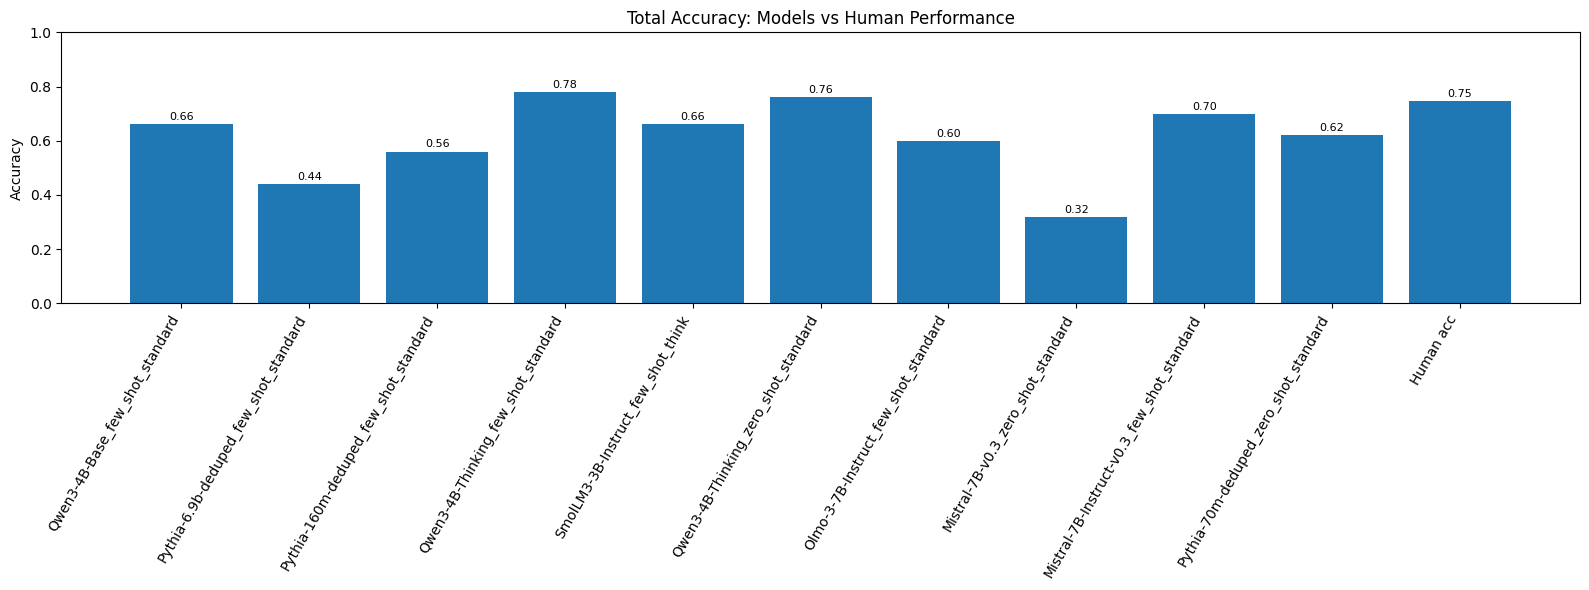

In [19]:
plt.figure(figsize=(16, 6))
plt.bar(range(len(total_accuracies)), total_accuracies)

plt.xticks(
    range(len(labels)),
    labels,
    rotation=60,
    ha="right"
)

plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Total Accuracy: Models vs Human Performance")

# value labels on bars
for i, acc in enumerate(total_accuracies):
    plt.text(i, acc + 0.015, f"{acc:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


## High performing vs Low performing

High Performing models

In [20]:
high_performing = [
    "final_resultss/final_results/Qwen3-4B-Thinking_few_shot_standard.csv",
    "final_resultss/final_results/Qwen3-4B-Thinking_zero_shot_standard.csv",
    "final_resultss/final_results/Mistral-7B-Instruct-v0.3_few_shot_standard.csv",
    "final_resultss/final_results/SmolLM3-3B-Instruct_few_shot_no_think.csv",
    "final_resultss/final_results/Qwen3-4B-Base_few_shot_standard.csv",
]


In [21]:
hlabels = []
htotal_accuracies = []

for row in modelss:
    if row[0] in high_performing:
        model_path, hard_acc, easy_acc, normal_acc, total_acc = row

        label = model_path.split("/")[-1].replace(".csv", "")
        hlabels.append(label)
        htotal_accuracies.append(total_acc)

In [22]:
hlabels.append("Human acc")
htotal_accuracies.append(human_accuracy)

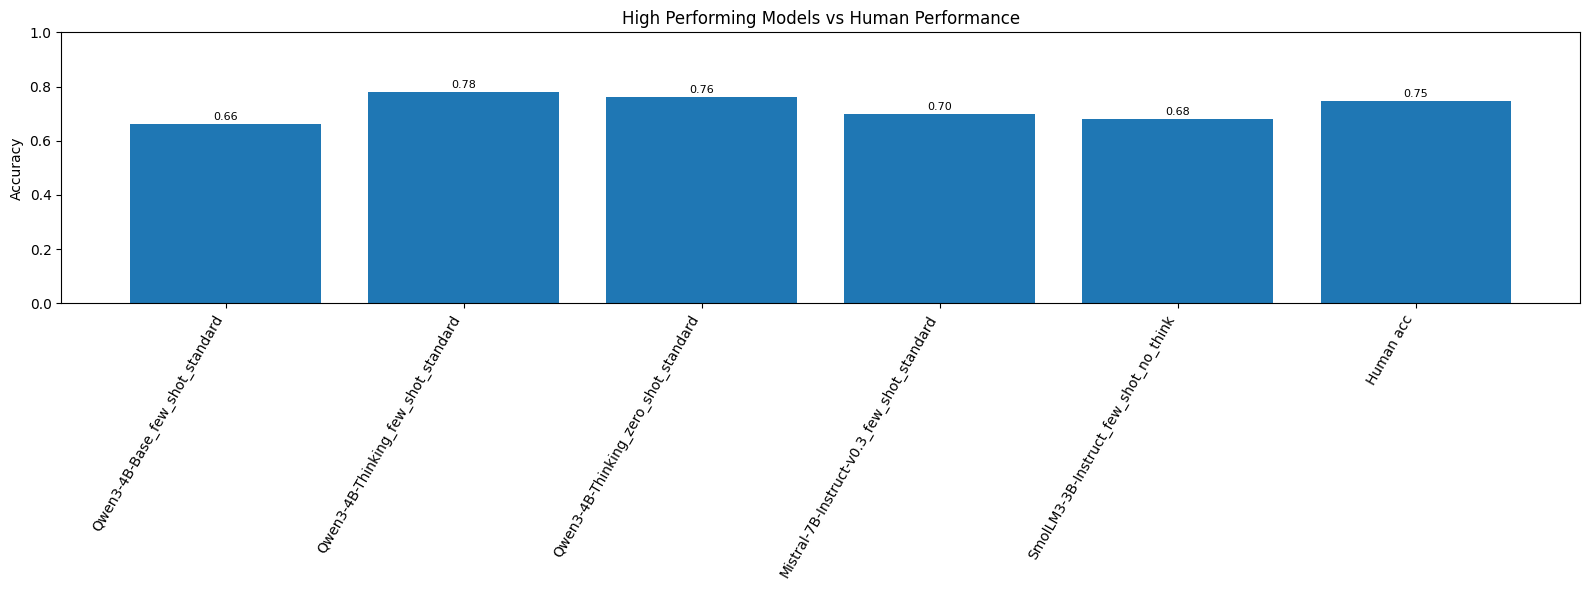

In [23]:
plt.figure(figsize=(16, 6))
plt.bar(range(len(htotal_accuracies)), htotal_accuracies)

plt.xticks(
    range(len(hlabels)),
    hlabels,
    rotation=60,
    ha="right"
)

plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("High Performing Models vs Human Performance")

# value labels on bars
for i, acc in enumerate(htotal_accuracies):
    plt.text(i, acc + 0.015, f"{acc:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


Low performing models

In [24]:
low_performing = [
    "final_resultss/final_results/Pythia-6.9b-deduped_few_shot_standard.csv",
    "final_resultss/final_results/Mistral-7B-v0.3_zero_shot_standard.csv",
]


In [25]:
llabels = []
ltotal_accuracies = []

for row in modelss:
    if row[0] in low_performing:
        model_path, hard_acc, easy_acc, normal_acc, total_acc = row

        label = model_path.split("/")[-1].replace(".csv", "")
        llabels.append(label)
        ltotal_accuracies.append(total_acc)

In [26]:
llabels.append("Human acc")
ltotal_accuracies.append(human_accuracy)

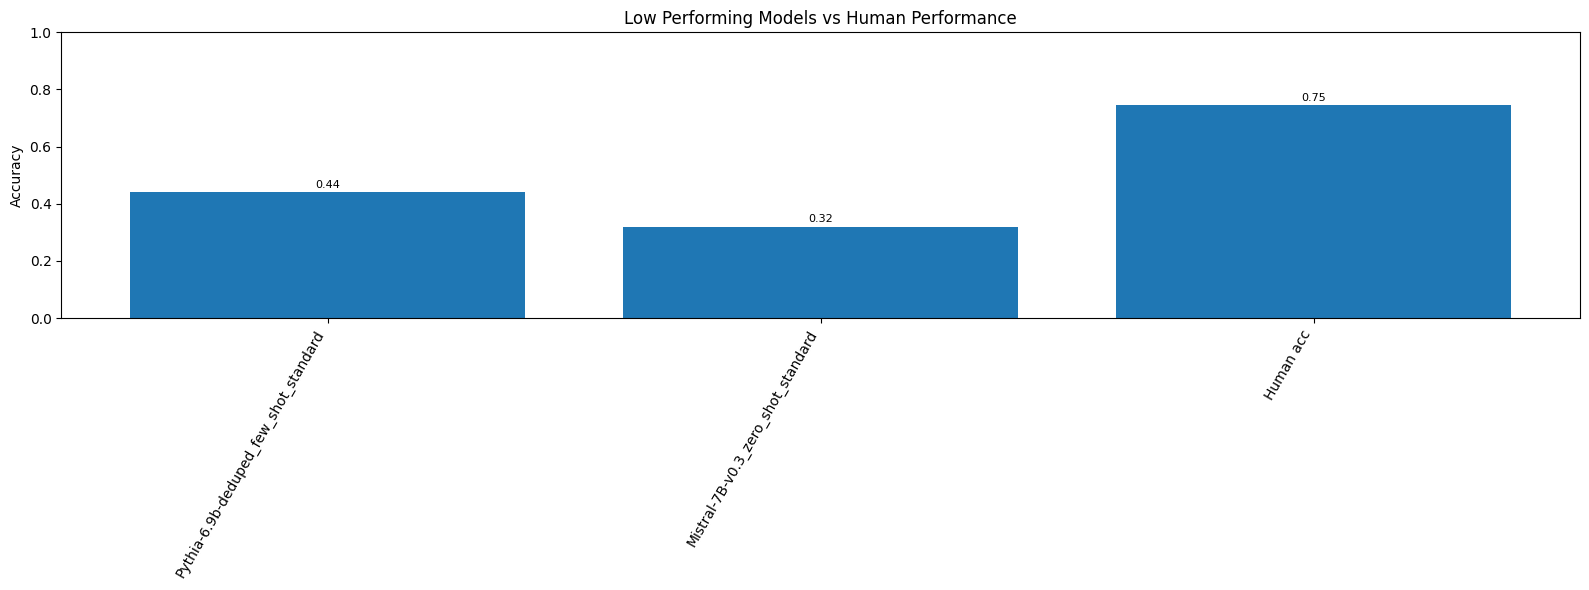

In [27]:
plt.figure(figsize=(16, 6))
plt.bar(range(len(ltotal_accuracies)), ltotal_accuracies)

plt.xticks(
    range(len(llabels)),
    llabels,
    rotation=60,
    ha="right"
)

plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Low Performing Models vs Human Performance")

# value labels on bars
for i, acc in enumerate(ltotal_accuracies):
    plt.text(i, acc + 0.015, f"{acc:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


## Few shot vs Zero shot

Few Shot models

In [28]:
few_shot_models = [
    "final_resultss/final_results/Qwen3-4B-Thinking_few_shot_standard.csv",
    "final_resultss/final_results/Mistral-7B-Instruct-v0.3_few_shot_standard.csv",
    "final_resultss/final_results/Qwen3-4B-Base_few_shot_standard.csv",
    "final_resultss/final_results/SmolLM3-3B-Instruct_few_shot_think.csv",
    "final_resultss/final_results/Olmo-3-7B-Instruct_few_shot_standard.csv",
    "final_resultss/final_results/Pythia-6.9b-deduped_few_shot_standard.csv",
    "final_resultss/final_results/Pythia-160m-deduped_few_shot_standard.csv",
]


In [29]:
flabels = []
ftotal_accuracies = []

for row in modelss:
    if row[0] in few_shot_models:
        model_path, hard_acc, easy_acc, normal_acc, total_acc = row

        label = model_path.split("/")[-1].replace(".csv", "")
        flabels.append(label)
        ftotal_accuracies.append(total_acc)

In [30]:
flabels.append("Human acc")
ftotal_accuracies.append(human_accuracy)

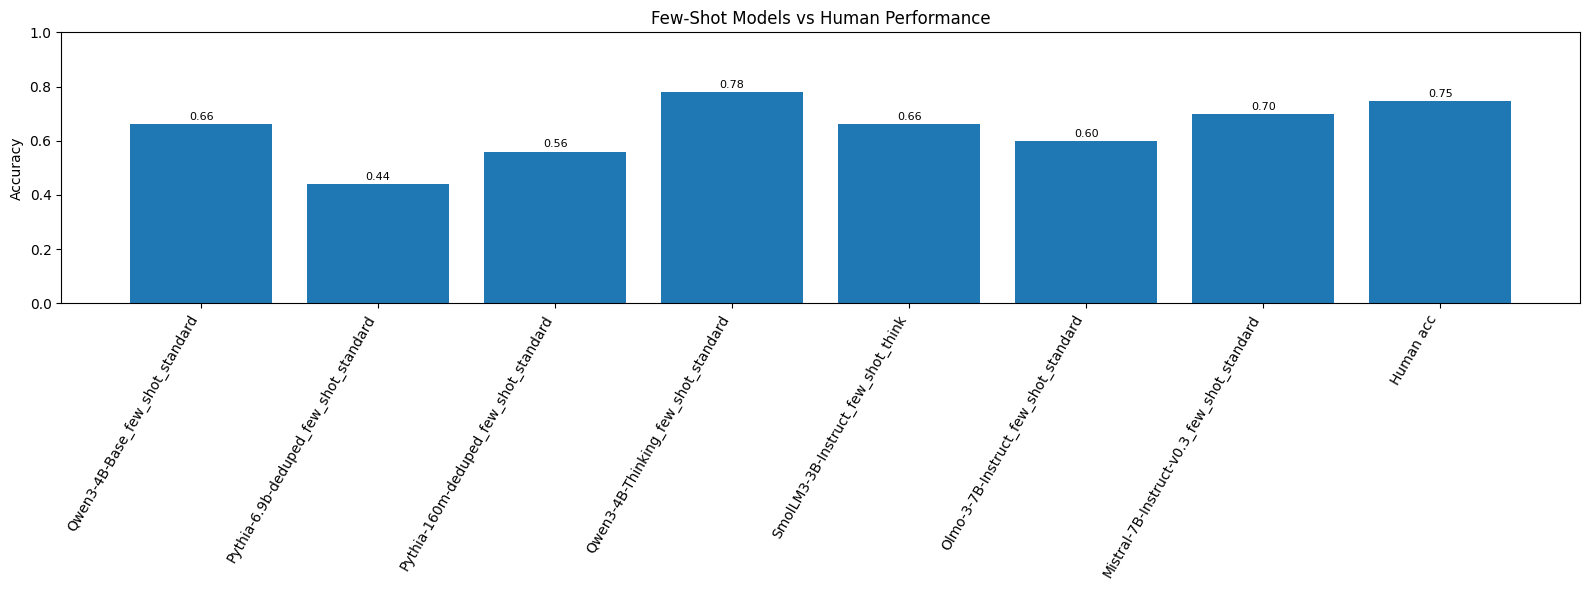

In [31]:
plt.figure(figsize=(16, 6))
plt.bar(range(len(ftotal_accuracies)), ftotal_accuracies)

plt.xticks(
    range(len(flabels)),
    flabels,
    rotation=60,
    ha="right"
)

plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Few-Shot Models vs Human Performance")

# value labels on bars
for i, acc in enumerate(ftotal_accuracies):
    plt.text(i, acc + 0.015, f"{acc:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


Zero shot models

In [32]:
zero_shot_models = [
    "final_resultss/final_results/Qwen3-4B-Thinking_zero_shot_standard.csv",
    "final_resultss/final_results/Mistral-7B-v0.3_zero_shot_standard.csv",
    "final_resultss/final_results/Pythia-70m-deduped_zero_shot_standard.csv",
]


In [33]:
zlabels = []
ztotal_accuracies = []

for row in modelss:
    if row[0] in zero_shot_models:
        model_path, hard_acc, easy_acc, normal_acc, total_acc = row

        label = model_path.split("/")[-1].replace(".csv", "")
        zlabels.append(label)
        ztotal_accuracies.append(total_acc)

In [34]:
zlabels.append("Human acc")
ztotal_accuracies.append(human_accuracy)

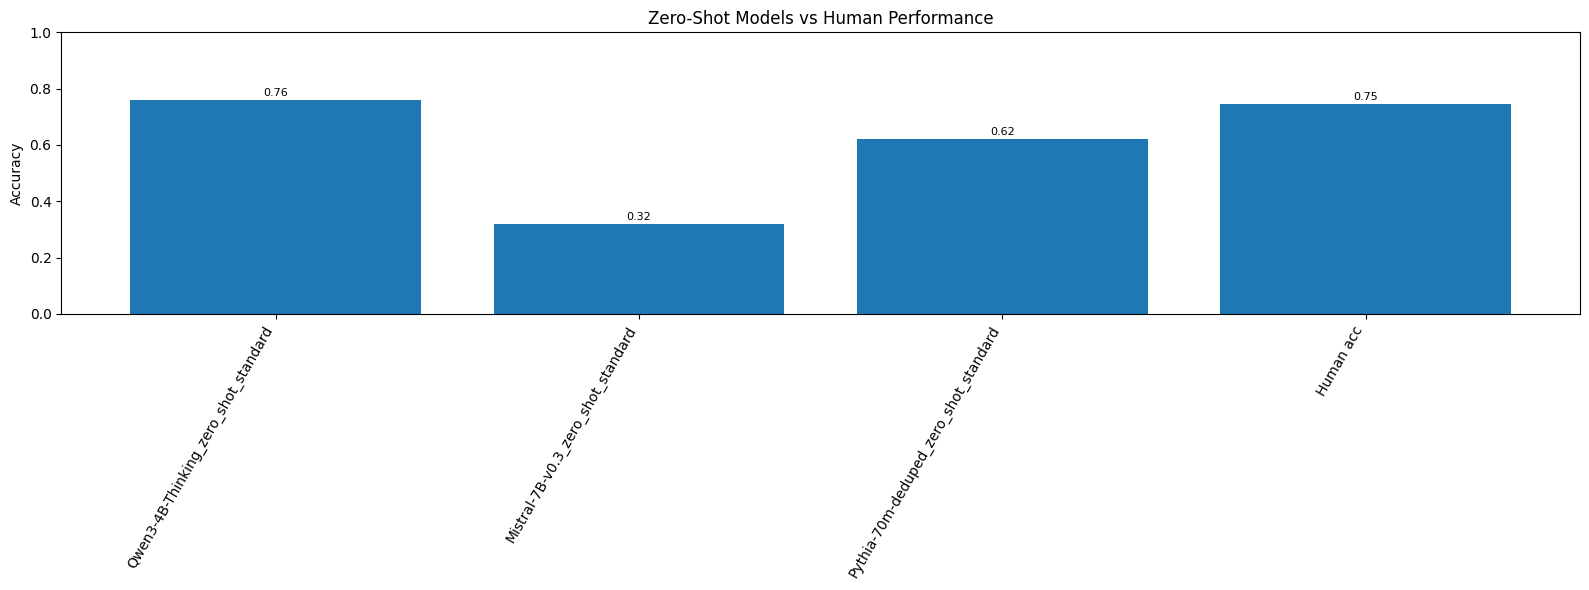

In [35]:
plt.figure(figsize=(16, 6))
plt.bar(range(len(ztotal_accuracies)), ztotal_accuracies)

plt.xticks(
    range(len(zlabels)),
    zlabels,
    rotation=60,
    ha="right"
)

plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Zero-Shot Models vs Human Performance")

# value labels on bars
for i, acc in enumerate(ztotal_accuracies):
    plt.text(i, acc + 0.015, f"{acc:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


## Thinking vs instruct

Thinking models

In [36]:
thinking_models = [
    "final_resultss/final_results/Qwen3-4B-Thinking_few_shot_standard.csv",
    "final_resultss/final_results/Qwen3-4B-Thinking_zero_shot_standard.csv",
    "final_resultss/final_results/SmolLM3-3B-Instruct_few_shot_think.csv",
]


In [37]:
tlabels = []
ttotal_accuracies = []

for row in modelss:
    if row[0] in thinking_models:
        model_path, hard_acc, easy_acc, normal_acc, total_acc = row

        label = model_path.split("/")[-1].replace(".csv", "")
        tlabels.append(label)
        ttotal_accuracies.append(total_acc)

In [38]:
tlabels.append("Human acc")
ttotal_accuracies.append(human_accuracy)

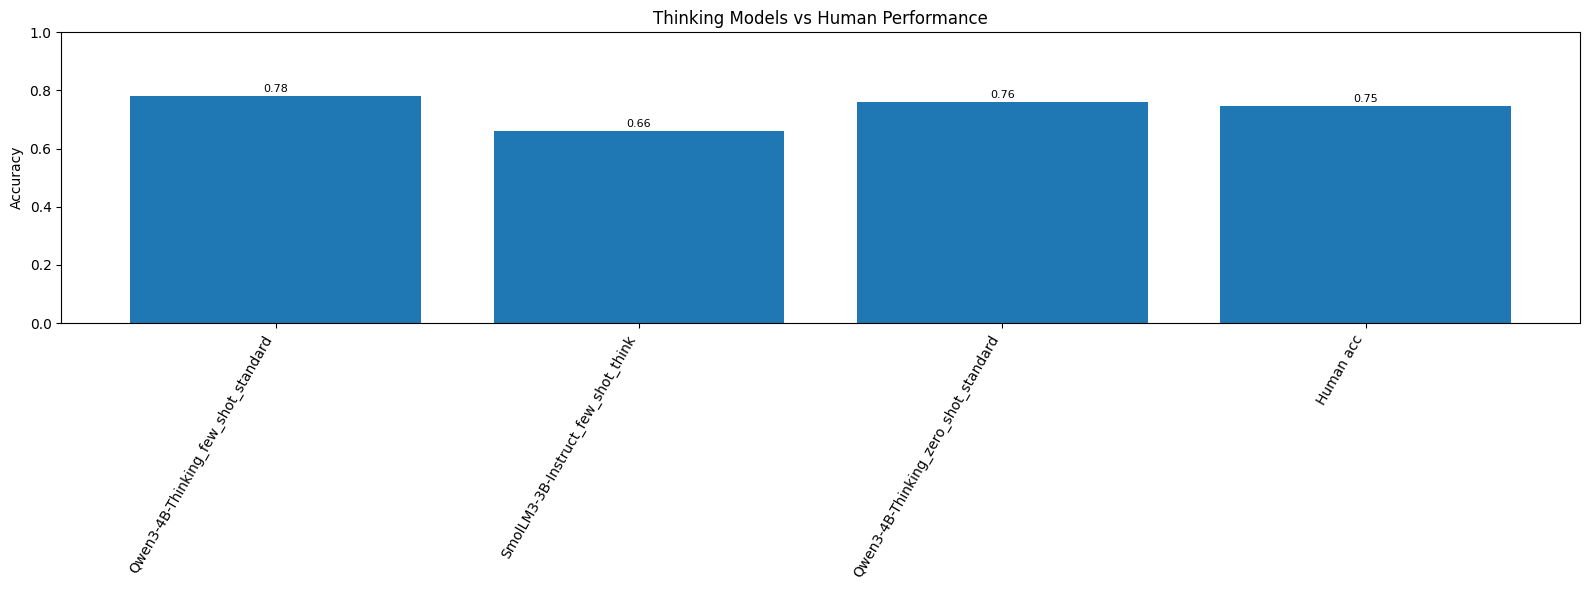

In [39]:
plt.figure(figsize=(16, 6))
plt.bar(range(len(ttotal_accuracies)), ttotal_accuracies)

plt.xticks(
    range(len(tlabels)),
    tlabels,
    rotation=60,
    ha="right"
)

plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Thinking Models vs Human Performance")

# value labels on bars
for i, acc in enumerate(ttotal_accuracies):
    plt.text(i, acc + 0.015, f"{acc:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


Instruct models

In [40]:
instruct_models = [
    "final_resultss/final_results/Mistral-7B-Instruct-v0.3_few_shot_standard.csv",
    "final_resultss/final_results/Olmo-3-7B-Instruct_few_shot_standard.csv",
    "final_resultss/final_results/Qwen3-4B-Base_few_shot_standard.csv",
]


In [41]:
ilabels = []
itotal_accuracies = []

for row in modelss:
    if row[0] in instruct_models:
        model_path, hard_acc, easy_acc, normal_acc, total_acc = row

        label = model_path.split("/")[-1].replace(".csv", "")
        ilabels.append(label)
        itotal_accuracies.append(total_acc)

In [42]:
ilabels.append("Human acc")
itotal_accuracies.append(human_accuracy)

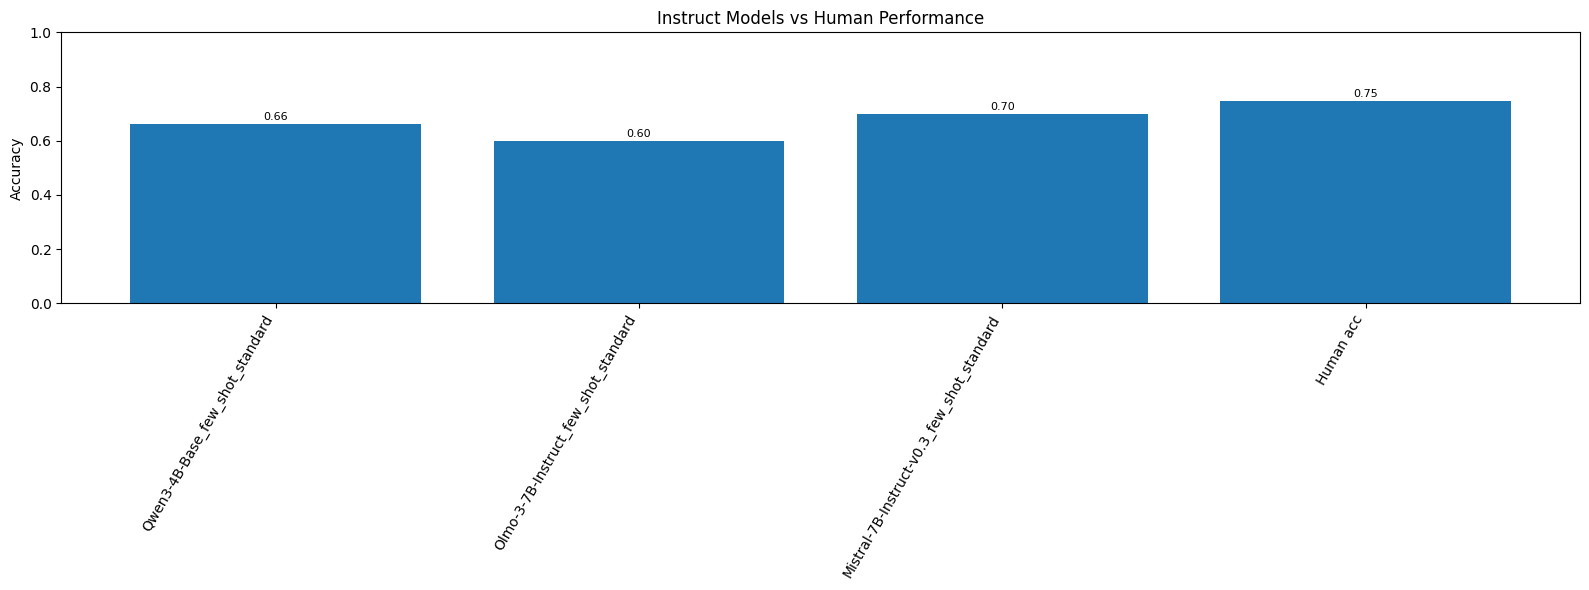

In [43]:
plt.figure(figsize=(16, 6))
plt.bar(range(len(itotal_accuracies)), itotal_accuracies)

plt.xticks(
    range(len(ilabels)),
    ilabels,
    rotation=60,
    ha="right"
)

plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Instruct Models vs Human Performance")

# value labels on bars
for i, acc in enumerate(itotal_accuracies):
    plt.text(i, acc + 0.015, f"{acc:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()
